## Warning!
This notebook is only for experimental purposes while learning, working with data of Ashrae Kaggle Competition. It won't be part of the final project, and will be removed from the repository.

### Training data sets structure

**train.csv**
* `building_id` - Foreign key for the building metadata.
* `meter` - The meter id code. Read as `{0: electricity, 1: chilledwater, 2: steam, 3: hotwater}`. Not every building has all meter types.
* `timestamp`  - When the measurement was taken
* `meter_reading` - The target variable. Energy consumption in kWh (or equivalent). Note that this is real data with measurement error, which we expect will impose a baseline level of modeling error.

**building_meta.csv**
* `site_id` - Foreign key for the weather files.
* `building_id` - Foreign key for training.csv
* `primary_use` - Indicator of the primary category of activities for the building based on EnergyStar property type definitions
* `square_feet` - Gross floor area of the building
* `year_built` - Year building was opened
* `floor_count` - Number of floors of the building

**weather_[train/test].csv**

Weather data from a meteorological station as close as possible to the site.

* `site_id`
* `air_temperature` - Degrees Celsius
* `cloud_coverage` - Portion of the sky covered in clouds, in oktas
* `dew_temperature` - Degrees Celsius
* `precip_depth_1_hr` - Millimeters
* `sea_level_pressure` - Millibar/hectopascals
* `wind_direction` - Compass direction (0-360)
* `wind_speed` - Meters per second

##  Loading data

In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import datetime as dt
import gc
from src.functions import utils as utl
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

In [ ]:
# Importing data
train = utl.import_data('../data/raw/train.csv') 


In [ ]:
building_meta = utl.import_data('../data/raw/building_metadata.csv')

In [2]:
weather_train = utl.import_data('../data/raw/weather_train.csv')

Memory usage of dataframe is 9.60 MB
Memory usage after optimization is: 2.65 MB
Decreased by 72.4%


In [ ]:
weather_train.to_csv('../data/interim/weather.csv')

## Wrangling


#### Data set `building_meta` 

In [ ]:
building_meta.shape

In [ ]:
building_meta.head()

In [ ]:
building_meta.info()

Feature `year_built`  is `float` type. We're casting it to `str`, removing the '.0' decimal too.

In [ ]:
building_meta['year_built'] = building_meta['year_built'].astype(str, errors='ignore')

In [ ]:
f = lambda x: x.replace('.0','')
building_meta['year_built'] = building_meta['year_built'].apply(f)

In [ ]:
building_meta.head()

** Missing values **

In [ ]:
building_meta.isna().sum()

In [ ]:
building_meta[building_meta['floor_count'].isna()].tail()

** Duplicated observations **

In [ ]:
building_meta[building_meta.duplicated()].sum()

#### Data set `train`

In [ ]:
train.shape

In [ ]:
train.head()

In [ ]:
train.info()

In [ ]:
train.isna().sum()

In [ ]:
train[train.duplicated()].sum()

#### Data set `weather_train`

In [ ]:
weather_train.tail()

In [ ]:
weather_train.info()

In [ ]:
weather_train.isna().sum()

In [ ]:
weather_train[weather_train.duplicated()].sum()

#### Merging data sets

In [ ]:
# train + building by FK 'building_id'
merge_1 = pd.merge(train, building_meta, how='left', on='building_id')

In [ ]:
merge_1.head()

In [ ]:
df = pd.merge(merge_1, weather_train, how='left', on=['site_id','timestamp'])

In [ ]:
df.head()

In [ ]:
del(train, weather_train, building_meta, merge_1)

In [ ]:
gc.collect()

In [ ]:
# Saving as csv file 
# df.to_csv('../data/processed/df_merged')

In [ ]:
df.info()

In [ ]:
df[df['floor_count'].notnull()]['floor_count'].head()

In [ ]:
(df.isna().sum()/df.shape[0])*100

In [ ]:
# Rearranging columns
cols = df.columns.tolist()

In [ ]:
cols = [
    'site_id', 
    'building_id', 
    'year_built', 
    'primary_use', 
    'floor_count', 
    'meter', 
    'timestamp', 
    'air_temperature', 
    'cloud_coverage',
    'dew_temperature',
    'precip_depth_1_hr',
    'sea_level_pressure',
    'wind_direction',
    'wind_speed',
    'meter_reading'
]

In [ ]:
df = df[cols]

In [ ]:
df.head()

In [ ]:
pd.to_datetime(df['timestamp'])

In [ ]:
df['timestamp'].describe()

## Data quality assessment and profiling

### Handling missing values

In [ ]:
df.isna().sum()

#### Variable `floor_count`

There're more than 16 million of `NaN` values in `floor_count`. They're likely to be buildings with only ground-floor. We're filling this missing values with `0` and, by the way, we're casting the type of this variable to int, as now it is a float.

In [ ]:
# df['floor_count'] = df['floor_count'].fillna(0.0).astype(int)

In [ ]:
# df.head()

In [ ]:
# df.isna().sum()

#### Remaining features

Let's visualize the distribution of missing values, using a sample of `df` data set, as it's very large and may cause memory errors:

In [ ]:
df_sample = df.sample(500000, replace=False, random_state=666)

In [ ]:
df_sample.to_csv('../data/interim/df_sample.csv')

In [ ]:
msno.matrix(df_sample)

In [ ]:
msno.bar(df_sample)

In [ ]:
msno.heatmap(df_sample)

There's high correlation in the distribution of `NaN`values between variables `air_temperature`, `dew_temperature` and `wind_speed`. Also there's is a significative correlation in the missing values distribution for `precip_depth_1_hr`and `sea_level_preassure`.

The feature with most of missing values is `cloud_coverage`, and it doesn't seem to be a correlation with any other feature, regarding `NaN` values.

We need a little more information to be able to decide what to do with missing values. A correlation plot between features could be a good advisor. We're only interested in weather variables, as the rest have no missing values.

### Missing values analysis in `weather_train` data set

In [3]:
# Percentage of missing values per column
(weather_train.isna().sum()/weather_train.shape[0]) * 100

site_id                0.000000
timestamp              0.000000
air_temperature        0.039350
cloud_coverage        49.489529
dew_temperature        0.080845
precip_depth_1_hr     35.979052
sea_level_pressure     7.596603
wind_direction         4.484414
wind_speed             0.217496
dtype: float64

In [4]:
# weather group by site
weather_by_site = weather_train.groupby('site_id')

In [5]:
weather_by_site.count()

,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
site_id,,,,,,,,
0,8784,8781,4954,8781,8783,8699,8534,8784
1,8763,8762,1701,8762,0,8711,8760,8763
2,8783,8782,6429,8782,8717,8739,8192,8778
3,8780,8776,5138,8774,8743,8622,8627,8776
4,8783,8783,4553,8781,7466,8710,8678,8783
5,8755,8753,2725,8753,0,0,8460,8752
6,8782,8772,5790,8772,8782,8607,8003,8743
7,8614,8614,0,8591,731,8606,8614,8614
8,8784,8781,4954,8781,8783,8699,8534,8784


In [21]:
weather_by_site.head()

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,2016-01-01 00:00:00,25.000000,6.0,20.000000,NaN,1019.5,0.0,0.000000
1,0,2016-01-01 01:00:00,24.406250,NaN,21.093750,-1.0,1020.0,70.0,1.500000
2,0,2016-01-01 02:00:00,22.796875,2.0,21.093750,0.0,1020.0,0.0,0.000000
3,0,2016-01-01 03:00:00,21.093750,2.0,20.593750,0.0,1020.0,0.0,0.000000
4,0,2016-01-01 04:00:00,20.000000,2.0,20.000000,-1.0,1020.0,250.0,2.599609
8784,1,2016-01-01 00:00:00,3.800781,NaN,2.400391,NaN,1021.0,240.0,3.099609
8785,1,2016-01-01 01:00:00,3.699219,0.0,2.400391,NaN,1021.5,230.0,2.599609
8786,1,2016-01-01 02:00:00,2.599609,0.0,1.900391,NaN,1022.0,0.0,0.000000
8787,1,2016-01-01 03:00:00,2.000000,0.0,1.200195,NaN,1022.5,170.0,1.500000
8788,1,2016-01-01 04:00:00,2.300781,0.0,1.799805,NaN,1022.5,110.0,1.500000


In [22]:
site_list = weather_train['site_id'].unique()

for site in site_list:
    print('SITE {} ============'.format(site))
    print(weather_train.loc[weather_train['site_id'] == site, :].isna().sum()
          /weather_train.loc[weather_train['site_id'] == site, :].shape[0]*100)
    print('\n')

SITE 0 ============
site_id                0.000000
timestamp              0.000000
air_temperature        0.034153
cloud_coverage        43.602004
dew_temperature        0.034153
precip_depth_1_hr      0.011384
sea_level_pressure     0.967668
wind_direction         2.846084
wind_speed             0.000000
dtype: float64


SITE 1 ============
site_id                 0.000000
timestamp               0.000000
air_temperature         0.011412
cloud_coverage         80.588839
dew_temperature         0.011412
precip_depth_1_hr     100.000000
sea_level_pressure      0.593404
wind_direction          0.034235
wind_speed              0.000000
dtype: float64


SITE 2 ============
site_id                0.000000
timestamp              0.000000
air_temperature        0.011386
cloud_coverage        26.801776
dew_temperature        0.011386
precip_depth_1_hr      0.751452
sea_level_pressure     0.500968
wind_direction         6.728908
wind_speed             0.056928
dtype: float64


SITE 3 =========

In [23]:
weather_train.loc[weather_train['site_id'] == 3, :].shape[0]

8780

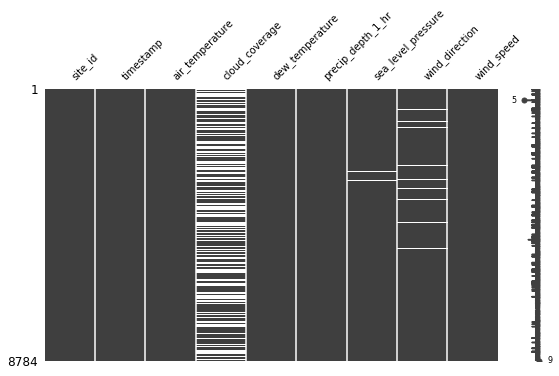

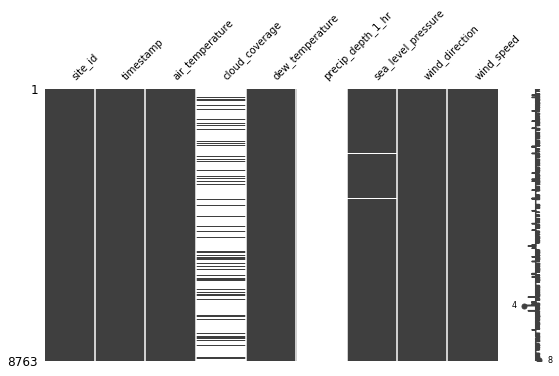

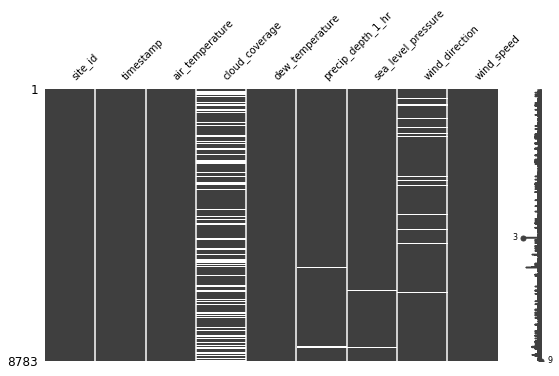

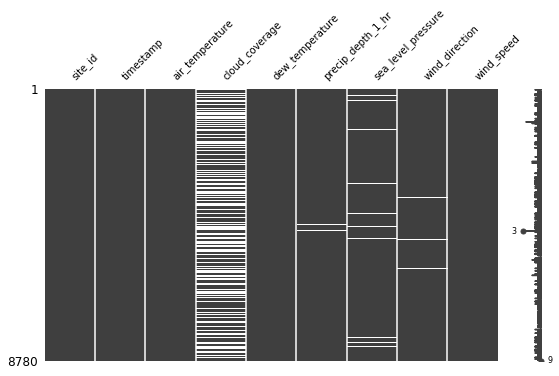

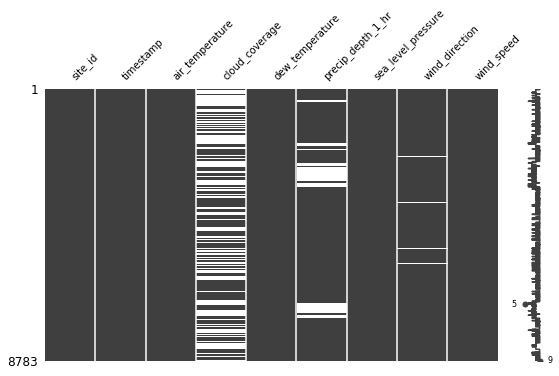

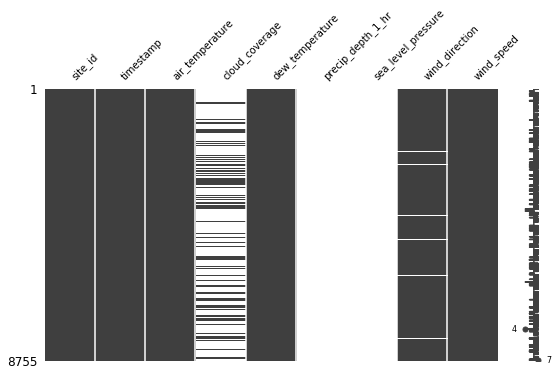

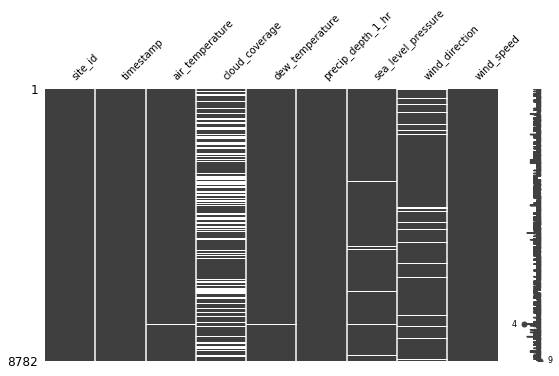

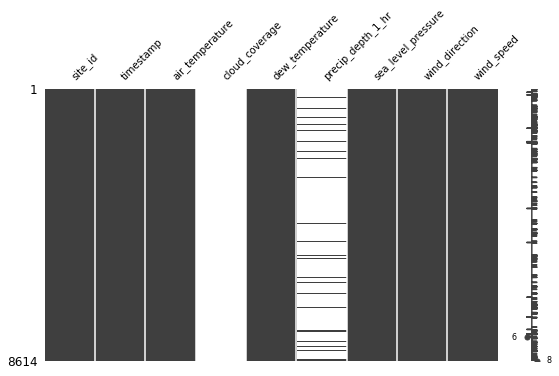

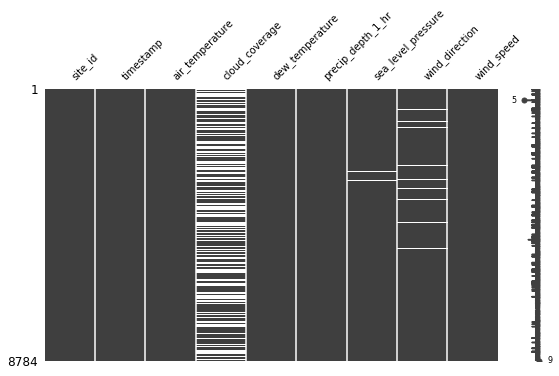

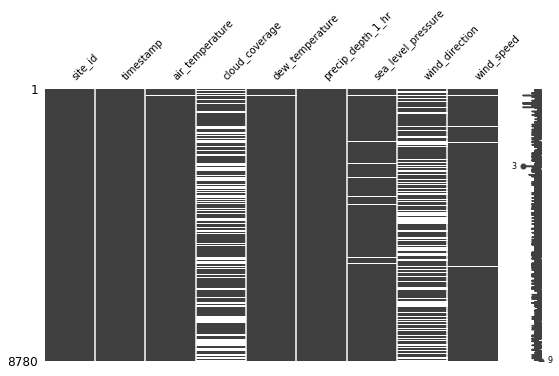

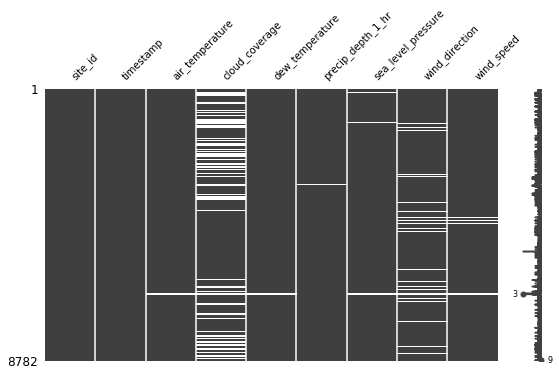

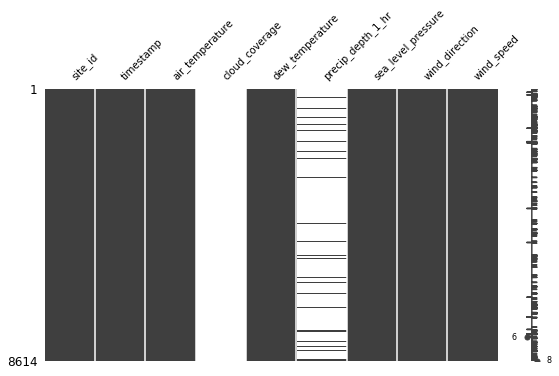

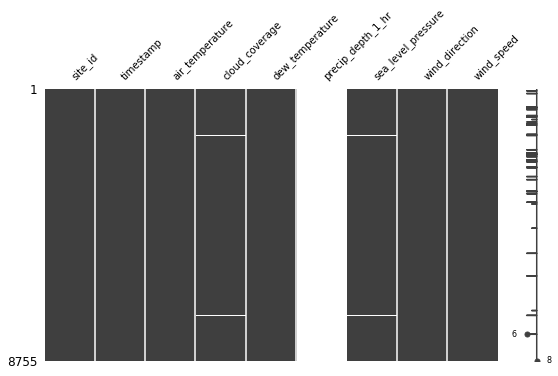

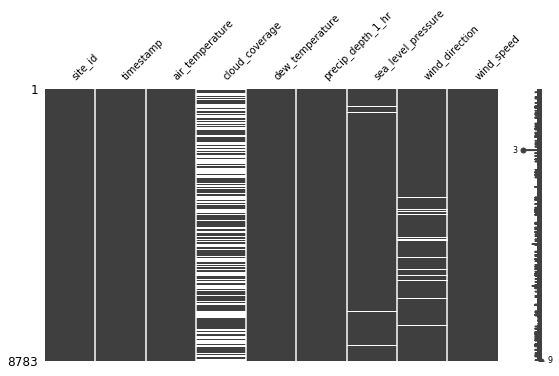

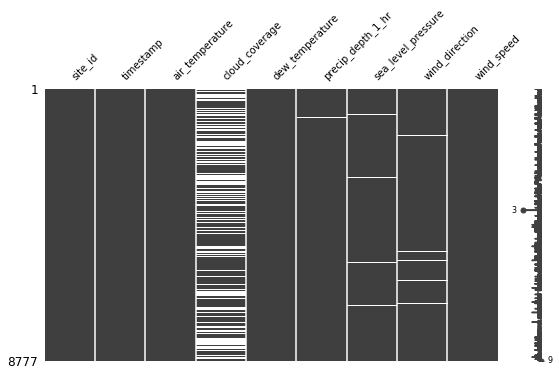

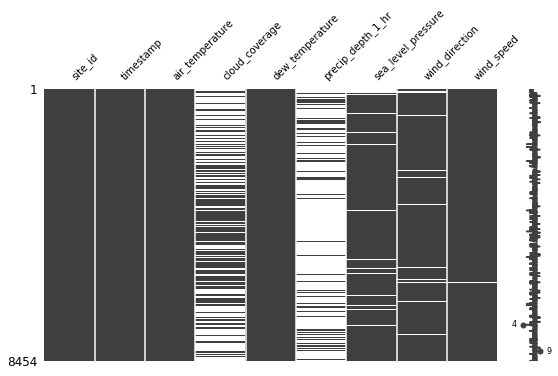

In [24]:
for site in site_list:
    msno.matrix(weather_train.loc[weather_train['site_id'] == site, :], figsize=(9,5), fontsize=10)

In [ ]:
for site in site_list:
    msno.heatmap(weather_train.loc[weather_train['site_id'] == site, :], figsize=(9,5), fontsize=10)

In [ ]:
corr = weather_by_site.corr()
corr.style.background_gradient(cmap='coolwarm')

In [26]:
(df.isna().sum()/df.shape[0])*100

NameError: name 'df' is not defined

In [25]:
gc.collect()

59820

In [ ]:
df.groupby('building_id').count()

In [ ]:
df_by_building = df.groupby('building_id')
del(df_by_building)

In [ ]:
df.loc[df['building_id']==1000,:].head()

In [ ]:
weather_train['air_temperature'].describe()

In [ ]:
weather_train.loc[weather_train['air_temperature'] > 47, 'site_id']

In [27]:
weather_train.loc[(weather_train['site_id']==2) & (weather_train['air_temperature'] > 47), :].head()

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
21649,2,2016-06-19 22:00:00,47.1875,2.0,-0.600098,0.0,1005.0,NaN,2.599609
21650,2,2016-06-19 23:00:00,47.1875,2.0,-2.199219,0.0,1004.0,NaN,2.599609
21651,2,2016-06-20 00:00:00,47.1875,2.0,-1.099609,0.0,1003.5,NaN,2.099609
21652,2,2016-06-20 01:00:00,47.1875,2.0,-1.099609,0.0,1003.0,300.0,5.699219


## Testing methods for filling gaps in `weather_train` data set
### Method 1: Interpolation with `interpolate()`

In [6]:
weather_site12 = weather_train.loc[weather_train['site_id'] == 12, :]

In [7]:
weather_site12.isna().sum()

site_id                  0
timestamp                0
air_temperature          0
cloud_coverage          59
dew_temperature          0
precip_depth_1_hr     8755
sea_level_pressure      56
wind_direction           1
wind_speed               0
dtype: int64

Imputation of 10 NaNs randomly

In [33]:
# Set 'timestamp' as index
weather12 = weather_site12.copy()
weather12['timestamp'] = pd.to_datetime(weather12['timestamp'])
weather12.index = weather12['timestamp']

In [9]:
weather12.sample(n=10, replace=False, random_state=1).index

DatetimeIndex(['2016-09-09 05:00:00', '2016-05-08 01:00:00',
               '2016-05-07 10:00:00', '2016-07-11 15:00:00',
               '2016-03-04 17:00:00', '2016-02-27 22:00:00',
               '2016-05-11 23:00:00', '2016-06-26 03:00:00',
               '2016-07-17 16:00:00', '2016-12-23 11:00:00'],
              dtype='datetime64[ns]', name='timestamp', freq=None)

In [10]:
weather12_with_nans = weather12.copy()
nan_indexes = weather12.sample(n=10, replace=False, random_state=1).index

In [ ]:
nan_indexes

In [11]:
weather12_with_nans.loc[nan_indexes, 'air_temperature'] = np.nan

In [12]:
weather12_with_nans.isna().sum()

site_id                  0
timestamp                0
air_temperature         10
cloud_coverage          59
dew_temperature          0
precip_depth_1_hr     8755
sea_level_pressure      56
wind_direction           1
wind_speed               0
dtype: int64

#### Method `time`

In [13]:
weather12_with_nans['air_temperature'].interpolate(method='time', inplace=True)

In [14]:
weather12_with_nans.isna().sum()

site_id                  0
timestamp                0
air_temperature          0
cloud_coverage          59
dew_temperature          0
precip_depth_1_hr     8755
sea_level_pressure      56
wind_direction           1
wind_speed               0
dtype: int64

In [15]:
aprox = weather12_with_nans.loc[list(nan_indexes), 'air_temperature']

In [16]:
real = weather12.loc[list(nan_indexes), 'air_temperature']

In [23]:
error = (abs(aprox - real)/real) * 100

In [30]:
np.median(error)
np.mean(error)

6.75

#### Method `linear`

In [ ]:
weather12_with_nans['air_temperature'].interpolate(method='linear', inplace=True)

In [ ]:
abs(weather12_with_nans.loc[list(nan_indexes), 'air_temperature'] -weather12.loc[list(nan_indexes), 'air_temperature'])

#### Method `quadratic`

In [ ]:
weather12_with_nans['air_temperature'].interpolate(method='quadratic', inplace=True)

In [ ]:
abs(weather12_with_nans.loc[list(nan_indexes), 'air_temperature'] -weather12.loc[list(nan_indexes), 'air_temperature'])

#### Method `cubic`

In [ ]:
weather12_with_nans.loc[nan_indexes, 'air_temperature'] = np.nan

In [ ]:
weather12_with_nans['air_temperature'].interpolate(method='cubic', inplace=True)

In [ ]:
abs(weather12_with_nans.loc[list(nan_indexes), 'air_temperature'] -weather12.loc[list(nan_indexes), 'air_temperature'])

#### Method `spline`

In [ ]:
weather12_with_nans.loc[nan_indexes, 'air_temperature'] = np.nan

In [ ]:
weather12_with_nans['air_temperature'].interpolate(method='spline', order=3, inplace=True)

In [ ]:
abs(weather12_with_nans.loc[list(nan_indexes), 'air_temperature'] -weather12.loc[list(nan_indexes), 'air_temperature'])

#### Method `polynomial`

In [ ]:
weather12_with_nans.loc[nan_indexes, 'air_temperature'] = np.nan

In [ ]:
weather12_with_nans['air_temperature'].interpolate(method='polynomial', order=5, inplace=True)

In [ ]:
abs(weather12_with_nans.loc[list(nan_indexes), 'air_temperature'] -weather12.loc[list(nan_indexes), 'air_temperature'])

The most accurate is the `time` method (or the linear, which returns exactly the same results).

### Function to automate the tests of `interpolate()`

In [63]:
def make_ts_index(df, timeCol):

    df_cpy = df.copy()
    df_cpy[timeCol] = pd.to_datetime(df_cpy[timeCol])
    df_cpy.index = df_cpy[timeCol]
    
    return df_cpy

In [59]:
def test_interpolate_methods(df, col, methods, n, order):
    '''
      Function to test several methods of the interpolate() pandas method
      for imputing NaN/NULL values. Inputs:
          - df: data frame with no missing values in the column we want to test.
          - col: string with the name of the variable.
          - methods: list of interpolate methods to test.
          - n: number of NaNs to be randomly imputed in the original data ts.
          - order: order for spline/polynomial methods.
    '''
    df_cpy = df.copy()
    
    # Random selection of the time indexes 
    indexes = df_cpy.sample(n, replace=False, random_state=1).index
    
    # Imput nan's in a copy of the original ts
    df_cpy.loc[nan_indexes, col] = np.nan
    
    for m in methods:
        if m in ['spline','polynomial']:
            df_cpy[col].interpolate(method=m, order=order, inplace=True)         
        else:
            # Interpolation
            df_cpy[col].interpolate(method=m, inplace=True)

            # Error calculation
            aprox = df_cpy.loc[list(nan_indexes), col]
            real = df.loc[list(nan_indexes), col]
            error_vec = (abs(aprox - real)/real) * 100
            err_mean = np.mean(error_vec)
            err_median = np.median(error_vec)

            # Set back the NaN's for the next method
            df_cpy.loc[nan_indexes, col] = np.nan
            
        print('Method {}:'.format(m))
        print('Error vector:', error_vec)
        print('Mean error: {0:.2f}'.format(err_mean))
        print('Median error: {0:.2f}'.format(err_median))
        print('===================================')

In [60]:
methods = ['linear', 'time', 'quadratic', 'cubic', 'spline']
test_interpolate_methods(weather12, 'air_temperature', methods, 10, 3)

Method linear:
Error vector: timestamp
2016-09-09 05:00:00     3.906250
2016-05-08 01:00:00     3.589844
2016-05-07 10:00:00     3.347656
2016-07-11 15:00:00     5.570312
2016-03-04 17:00:00     0.000000
2016-02-27 22:00:00    37.500000
2016-05-11 23:00:00     6.757812
2016-06-26 03:00:00     1.302734
2016-07-17 16:00:00     4.105469
2016-12-23 11:00:00     1.447266
Name: air_temperature, dtype: float16
Mean error: 6.75
Median error: 3.75
Method time:
Error vector: timestamp
2016-09-09 05:00:00     3.906250
2016-05-08 01:00:00     3.589844
2016-05-07 10:00:00     3.347656
2016-07-11 15:00:00     5.570312
2016-03-04 17:00:00     0.000000
2016-02-27 22:00:00    37.500000
2016-05-11 23:00:00     6.757812
2016-06-26 03:00:00     1.302734
2016-07-17 16:00:00     4.105469
2016-12-23 11:00:00     1.447266
Name: air_temperature, dtype: float16
Mean error: 6.75
Median error: 3.75
Method quadratic:
Error vector: timestamp
2016-09-09 05:00:00     0.732422
2016-05-08 01:00:00     4.714844
2016-05-